## Pitch Modeling

Goals for a new approach to pitch modeling:

- Improve the target variable. Most stuff models use target metrics like context-neutral re24/re288 run values, context-specific run values like `delta_run_exp`, or called/swinging strike rate (CSW%). My approach will use expected run value as seen in expected wOBA, which uses exit velocity and launch angle to predict wOBA. I won't be using wOBA as a base metric due to reasons I've discussed [here](https://sam-walsh.github.io/posts/fixing-xwoba/) and [here](https://sam-walsh.github.io/posts/double-plays/). Instead I will be predicting RE288 run values for balls in play with expected outcomes to reduce the noise of the target metric, while still taking into account context-specific outcomes like double plays and sacrifice flies.

- Improve location modeling. Scott Powers, former Dodgers Analyst, and Professor of Sports Analytics and his student Vicente Iglesias recently gave a presentation at Saberseminar about improving location modeling using bayesian hierarchical models. More about that [here](https://github.com/saberpowers/predictive-pitch-score). I will be taking a similar approach which will help improve location modeling, especially in small sample sizes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pybaseball as pb
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

pd.set_option('display.max_columns', None)

### Data loading, merging, and transformations

Load in data from 2020-2023 seasons. 2020 was the first season where baseball-savant used hawkeye data, which includes information on the spin axis of the ball. This may help with modeling pitches that benefit from late break due to the Seam Shifted Effect. Data for observed and inferred spin axis is sourced from [baseball-savant](https://baseballsavant.mlb.com/leaderboard/spin-direction-pitches).

In [2]:
df_all = pd.DataFrame()
for year in range(2015, 2024):
    df_year = pd.read_csv(f'statcast_data/{year}.csv')
    df_all = pd.concat([df_all, df_year])

### Data Description

- `pitch_type`: The type of pitch thrown by the pitcher.
- `player_name`: The name of the player who threw the pitch.
- `release_speed`: The speed of the pitch at the moment it was released by the pitcher.
- `release_pos_x`: The horizontal position where the pitch was released.
- `release_pos_z`: The vertical position where the pitch was released.
- `description`: A brief description of the pitch outcome.
- `events`: The event that occurred as a result of the pitch (e.g., strike, ball, hit, etc.).
- `p_throws`: The hand with which the pitcher throws (R for right, L for left).
- `pfx_x`: The horizontal movement of the pitch, in inches, from the perspective of the pitcher.
- `pfx_z`: The vertical movement of the pitch, in inches, from the perspective of the pitcher.
- `plate_x`: The horizontal location of the pitch when it crossed home plate.
- `plate_z`: The vertical location of the pitch when it crossed home plate.
- `launch_speed`: The speed of the ball off the bat, if the pitch was hit.
- `launch_angle`: The angle at which the ball left the bat, if the pitch was hit.
- `release_spin_rate`: The spin rate of the ball when it was released by the pitcher.
- `release_extension`: The distance from the front of the pitching rubber to the point where the pitcher released the ball.
- `at_bat_number`: The number of the current at-bat in the game.
- `pitch_number`: The number of the current pitch in the at-bat.
- `delta_run_exp`: The change in expected runs from the start of the play to the end of the play.
- `active_spin_formatted`: The proportion of the total spin of the ball that contributes to its movement via magnus effect.
- `hawkeye_measured`: The measured spin direction of the ball, in degrees, from the perspective of the pitcher at release.
- `movement_inferred`: The inferred spin direction of the ball, in degrees, from the perspective of the pitcher inferred from vertical and horizontal movement.
- `diff_measured_inferred`: The difference between the measured and inferred spin direction of the ball. Corresponds to the magnitude of the seam-shifted effect.



In [3]:
df_all.groupby('events')['delta_run_exp'].mean()

events
catcher_interf                  0.361251
caught_stealing_2b             -0.219014
caught_stealing_3b             -0.343158
caught_stealing_home           -0.346719
double                          0.765782
double_play                    -0.358528
ejection                       -0.163667
field_error                     0.449070
field_out                      -0.238023
fielders_choice                 0.697381
fielders_choice_out            -0.321947
force_out                      -0.432533
game_advisory                  -0.152222
grounded_into_double_play      -0.506435
hit_by_pitch                    0.374570
home_run                        1.375466
intent_walk                          NaN
other_out                      -0.238075
passed_ball                    -0.104143
pickoff_1b                     -0.298727
pickoff_2b                     -0.358667
pickoff_3b                     -0.266313
pickoff_caught_stealing_2b     -0.336500
pickoff_caught_stealing_3b     -0.333778
pickoff_c

### Train model to get expected run value based on launch angle and exit velocity

Calculate spray angle

In [4]:
import math

def calculate_spray_angle(df):
    # Create a copy of the dataframe to avoid modifying the original one
    df_copy = df.copy()

    # Calculate adjusted hit coordinates
    df_copy['hc_x_adj'] = df_copy['hc_x'].sub(126)
    df_copy['hc_y_adj'] = 254.5 - df_copy['hc_y']

    # Define rotation matrix
    rad = -math.pi/4
    rotation_mat = np.array([[math.cos(rad), math.sin(rad)],
                             [-math.sin(rad), math.cos(rad)]])

    # Apply rotation matrix to adjusted hit coordinates
    df_copy[['field_x', 'field_y']] = df_copy[['hc_x_adj', 'hc_y_adj']].dot(rotation_mat)

    # Calculate spray angle from inverse tangent function of transformed hit coordinates
    df_copy['theta'] = np.arctan(df_copy['field_y'].div(df_copy['field_x']))
    df_copy['spray_angle'] = df_copy['theta'].mul(180/math.pi)

    # Adjust spray angle for pull side of lefties and righties (closer to zero is pull side)
    df_copy['spray_angle_adj'] = np.where(df_copy['stand'] == 'R', df_copy['spray_angle'].mul(-1).add(90), df_copy['spray_angle'])
    df_copy['spray_angle_adj'] = (df_copy['spray_angle_adj'] / 10).round() * 10
    # Assign NaN to the rows where spray angle cannot be calculated
    df_copy.loc[df_copy[['hc_x', 'hc_y']].isna().any(axis=1), ['field_x', 'field_y', 'theta', 'spray_angle', 'spray_angle_adj']] = np.nan

    return df_copy

In [5]:
df_all = calculate_spray_angle(df_all)

In [6]:
mean_run_values_by_year = df_all.groupby(['game_year', 'events'])['delta_run_exp'].mean().round(2)
df_all['mean_run_value'] = df_all.set_index(['game_year', 'events']).index.map(mean_run_values_by_year)

- swinging strike: swinging_strike, bunt_foul_tip, swinging_strike_blocked, foul_tip, missed_bunt
- ball: ball, blocked_ball
- foul: foul, foul_bunt, foul_pitchout

In [16]:
description_mapping = {
    'swinging_strike': 'swinging_strike', 
    'bunt_foul_tip': 'swinging_strike', 
    'swinging_strike_blocked': 'swinging_strike', 
    'foul_tip': 'swinging_strike', 
    'missed_bunt': 'swinging_strike',
    'ball': 'ball', 
    'blocked_ball': 'ball',
    'foul': 'foul', 
    'foul_bunt': 'foul', 
    'foul_pitchout': 'foul',
    'called_strike': 'called_strike'
}

df_all['description_new'] = df_all['description'].map(description_mapping)


In [17]:
non_bip_run_values = df_all.loc[df_all['description']!='hit_into_play'].groupby('description_new')['delta_run_exp'].mean().round(2)
non_bip_run_values

description_new
ball               0.06
called_strike     -0.06
foul              -0.04
swinging_strike   -0.12
Name: delta_run_exp, dtype: float64

In [18]:
df_all.loc[df_all['description_new'].notna(), 'mean_run_value'] = df_all.loc[df_all['description_new'].notna(), 'description_new'].map(non_bip_run_values)


In [19]:
# check if yearly implementation of linear weights is correct
df_all.loc[df_all['events']=='home_run'].groupby('game_year')['mean_run_value'].mean()

game_year
2015    1.39
2016    1.37
2017    1.37
2018    1.37
2019    1.37
2020    1.38
2021    1.38
2022    1.39
2023    1.37
Name: mean_run_value, dtype: float64

In [20]:
## subset for balls in play with launch speed and angle
df_all_bip = df_all.dropna(subset=['launch_speed', 'launch_angle', 'spray_angle_adj', 'mean_run_value'])
df_all_bip.shape

(943352, 103)

Convert features to integers for faster training and predictions

In [21]:
df_all_bip['launch_speed'] = df_all_bip['launch_speed'].round().astype(int)
df_all_bip['launch_angle'] = df_all_bip['launch_angle'].round().astype(int)
df_all_bip['spray_angle_adj'] = df_all_bip['spray_angle_adj'].astype(int)

C:\Users\wampl\AppData\Local\Temp\ipykernel_5096\2501300249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_bip['launch_speed'] = df_all_bip['launch_speed'].round().astype(int)
C:\Users\wampl\AppData\Local\Temp\ipykernel_5096\2501300249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_bip['launch_angle'] = df_all_bip['launch_angle'].round().astype(int)
C:\Users\wampl\AppData\Local\Temp\ipykernel_5096\2501300249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [24]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Define features and target
X = df_all_bip[['launch_speed', 'launch_angle', 'spray_angle_adj']].values
y = df_all_bip['mean_run_value'].values

## Split data into training, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [93]:

# def objective(trial):
#     param = {
#         'tree_method': 'gpu_hist',  # Use GPU acceleration
#         'lambda': trial.suggest_float(
#             'lambda', 1e-3, 10.0, log=True
#         ),
#         'alpha': trial.suggest_float(
#             'alpha', 1e-3, 10.0, log=True
#         ),
#         'colsample_bytree': trial.suggest_categorical(
#             'colsample_bytree', [0.5, 0.7, 0.9, 1.0]
#         ),
#         'subsample': trial.suggest_categorical(
#             'subsample', [0.6, 0.7, 0.8, 1.0]
#         ),
#         'learning_rate': trial.suggest_float(
#             'learning_rate', 0.005, 0.03, log=True
#         ),
#         'n_estimators': trial.suggest_categorical(
#             "n_estimators", [1000, 2000, 5000, 10000]
#         ),
#         'max_depth': trial.suggest_categorical(
#             'max_depth', [2, 3, 4, 5, 7, 9, 11, 13]
#         ),
#         'random_state': 42,
#         'min_child_weight': trial.suggest_int(
#             'min_child_weight', 1, 300
#         ),
#     }
#     model = xgb.XGBRegressor(**param)  

#     model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

#     preds = model.predict(X_val)
#     rmse = mean_squared_error(y_val, preds, squared=False)
#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=25)

In [94]:
# xgb_params = study.best_params
# xgb_params['random_state'] = 42
# xgb_params['tree_method'] = 'gpu_hist'
# xgb_reg = xgb.XGBRegressor(**xgb_params)
# xgb_reg.fit(X_train, y_train)

# joblib.dump(xgb_reg, 'xgb_reg.joblib')


In [25]:

xgb_reg = joblib.load('xgb_reg.joblib')


[22:33:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:415: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
[22:33:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:425: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.


In [26]:

## Score the model on the test set
preds_test = xgb_reg.predict(X_test)
rmse_test = mean_squared_error(y_test, preds_test, squared=False)
print(f'Test RMSE: {rmse_test:.4f}')


Test RMSE: 0.3191


In [27]:
xgb_reg.fit(X, y)

XGBoostError: [22:33:19] c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\common\common.h:239: XGBoost version not compiled with GPU support.

0
10
20
30
40
50
60
70
80
90


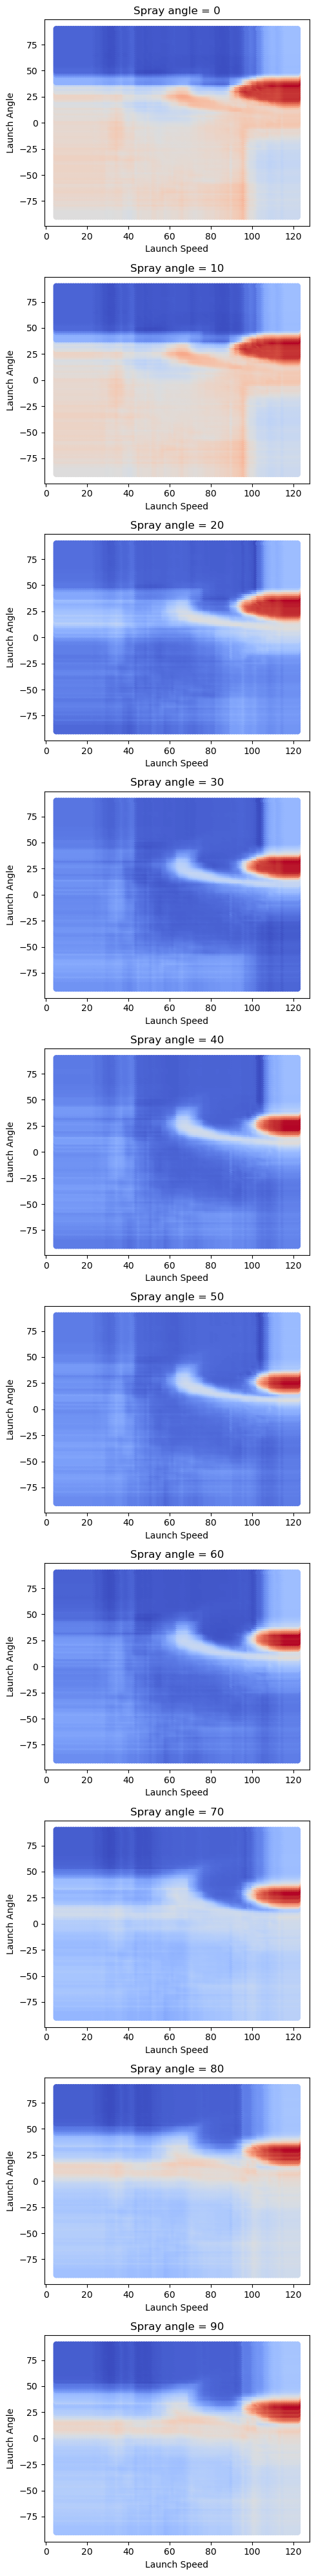

In [28]:
# Generate a grid of launch angles and exit velocities
launch_speeds = np.linspace(df_all_bip['launch_speed'].min(), df_all_bip['launch_speed'].max(), 100)
launch_angles = np.linspace(df_all_bip['launch_angle'].min(), df_all_bip['launch_angle'].max(), 100)
hit_direction_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

launch_speeds_grid, launch_angles_grid = np.meshgrid(launch_speeds, launch_angles)

fig, axs = plt.subplots(len(hit_direction_values), figsize=(5, 4*len(hit_direction_values)))

for i, hit_direction in enumerate(hit_direction_values):
    print(hit_direction)
    X_grid = np.c_[launch_speeds_grid.ravel(), launch_angles_grid.ravel(), np.full(launch_speeds_grid.ravel().shape, hit_direction)]
    y_grid = xgb_reg.predict(X_grid)
    y_grid = y_grid.reshape(launch_speeds_grid.shape)

    axs[i].scatter(launch_speeds_grid, launch_angles_grid, c=y_grid, cmap='coolwarm')
    axs[i].set_title(f'Spray angle = {hit_direction}')
    axs[i].set_xlabel('Launch Speed')
    axs[i].set_ylabel('Launch Angle')

plt.tight_layout()
plt.show()

In [29]:
df_all['predicted_run_value'] = df_all['mean_run_value']
mask = (df_all['description'] == 'hit_into_play') & df_all[['launch_speed', 'launch_angle', 'spray_angle_adj']].notnull().all(axis=1)
df_all.loc[mask, 'predicted_run_value'] = xgb_reg.predict(df_all.loc[mask, ['launch_speed', 'launch_angle', 'spray_angle_adj']])


In [30]:
df_all.loc[df_all['events']=='home_run', ['launch_speed', 'launch_angle', 'stand', 'spray_angle_adj', 'predicted_run_value']].nsmallest(10, 'predicted_run_value')

,launch_speed,launch_angle,stand,spray_angle_adj,predicted_run_value
490662,97.2,51.0,R,70.0,-0.260349
703906,102.3,40.0,R,50.0,-0.259233
727577,94.6,35.0,L,50.0,-0.258104
204498,102.3,50.0,R,20.0,-0.253460
370711,100.4,42.0,R,40.0,-0.252304
145465,98.8,38.0,R,40.0,-0.249456
339212,98.2,38.0,R,40.0,-0.249456
383239,98.4,38.0,L,40.0,-0.249456
501745,100.8,44.0,L,50.0,-0.241786
7216,91.9,35.0,L,60.0,-0.240656


In [31]:
df_all.loc[df_all['description']=='hit_into_play'].groupby('events')[['delta_run_exp', 'predicted_run_value']].mean()

,delta_run_exp,predicted_run_value
events,,
catcher_interf,0.503235,0.413580
double,0.765782,0.458247
double_play,-0.358528,0.039267
ejection,-0.098000,-0.212700
field_error,0.449070,-0.075014
field_out,-0.238021,-0.106670
fielders_choice,0.697381,-0.087328
fielders_choice_out,-0.321947,-0.144713
force_out,-0.432533,-0.150328


<Axes: xlabel='launch_speed', ylabel='launch_angle'>

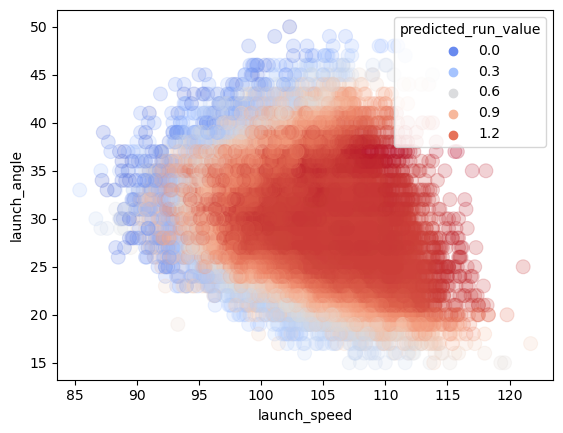

In [32]:
pull_hr = df_all.loc[(df_all['events']=='home_run') & (df_all['spray_angle_adj'] < 30)]

sns.scatterplot(x='launch_speed', y='launch_angle', hue='predicted_run_value', data=pull_hr, palette='coolwarm', edgecolor=None, s=100, alpha=0.2)

<Axes: xlabel='launch_speed', ylabel='launch_angle'>

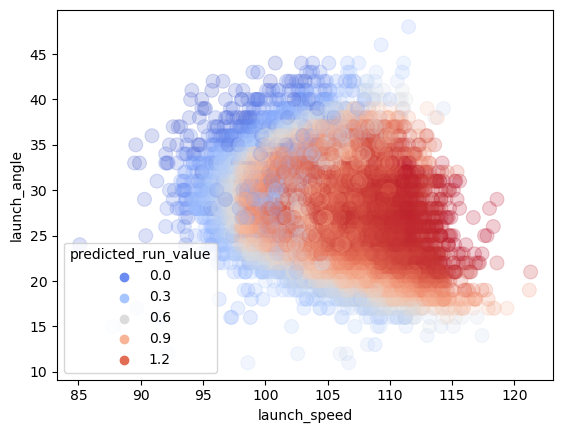

In [33]:
center_hr = df_all.loc[(df_all['events']=='home_run') & (df_all['spray_angle_adj'].isin(range(30, 60)))]
sns.scatterplot(x='launch_speed', y='launch_angle', hue='predicted_run_value', data=center_hr, palette='coolwarm', edgecolor=None, s=100, alpha=0.2)

<Axes: xlabel='launch_speed', ylabel='launch_angle'>

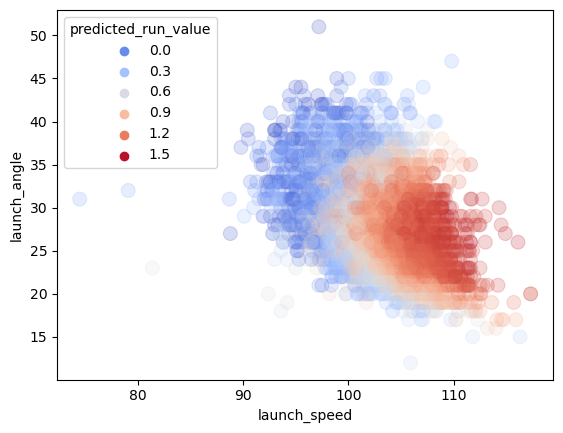

In [34]:
oppo_hr = df_all.loc[(df_all['events']=='home_run') & (df_all['spray_angle_adj'].isin(range(60, 90)))]
sns.scatterplot(x='launch_speed', y='launch_angle', hue='predicted_run_value', data=oppo_hr, palette='coolwarm', edgecolor=None, s=100, alpha=0.2)

In [35]:
df_all.loc[df_all['events']=='home_run', ['launch_speed', 'launch_angle', 'stand', 'spray_angle_adj', 'predicted_run_value']].nlargest(10, 'predicted_run_value')


,launch_speed,launch_angle,stand,spray_angle_adj,predicted_run_value
447874,111.3,23.0,L,80.0,1.524865
482660,109.0,31.0,L,70.0,1.522611
594462,107.0,30.0,R,80.0,1.519585
553146,109.6,30.0,R,70.0,1.511738
356984,111.1,28.0,L,70.0,1.505002
688878,111.6,26.0,R,70.0,1.502214
317917,116.1,26.0,L,60.0,1.494094
321625,108.2,30.0,R,70.0,1.485755
59231,108.9,30.0,R,70.0,1.485755
309229,109.3,29.0,R,70.0,1.482049


In [36]:
df = df_all.loc[(df_all['pitch_type']=='FF')].groupby(['player_name', 'pitch_type'], as_index=False)['predicted_run_value'].agg(['mean', 'count']).reset_index()
filtered_df = df.query('count > 1000').sort_values('mean', ascending=True)
filtered_df.head(50)

,index,player_name,pitch_type,mean,count
1298,1298,"Oh, Seunghwan",FF,-0.016625,2169
529,529,"Fields, Josh",FF,-0.014849,1723
117,117,"Bautista, Félix",FF,-0.014329,1313
126,126,"Bednar, David",FF,-0.013910,1695
1453,1453,"Reed, Addison",FF,-0.013255,2538
2008,2008,"deGrom, Jacob",FF,-0.012472,7681
436,436,"Doolittle, Sean",FF,-0.011783,3765
757,757,"Hendriks, Liam",FF,-0.011545,4103
1550,1550,"Ryan, Joe",FF,-0.011364,3084
397,397,"Dayton, Grant",FF,-0.011092,1301


In [37]:
df_all.loc[(df_all['pitcher']==690986) & (df_all['pitch_type']=='FF') & (df_all['p_throws'] == 'L'), 'az'].mean()

-16.005444934411166

In [38]:
df_all_spin = pd.DataFrame()

spin_dir_columns = ['player_id', 'api_pitch_type', 'active_spin_formatted', 'hawkeye_measured', 'movement_inferred', 'diff_measured_inferred']
for year in range(2020, 2024):
    df_year = df_all.loc[df_all['game_year']==year]
    spin_dir_year = pd.read_csv(f"statcast_data/spin-direction-{year}.csv")[spin_dir_columns].round(1)
    df_year = pd.merge(df_year, spin_dir_year, left_on=['pitcher', 'pitch_type'], right_on=['player_id', 'api_pitch_type'], how='left')
    df_all_spin = pd.concat([df_all_spin, df_year])

df_all_spin.to_csv('statcast_data/df_all_spin.csv')